## Import the necessary libraries

I want to download with yfinance the prices of four ETF for 5 years and find the optimal weights for the portfolio.

In [13]:
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

##Download the closing prices of the following ETF: SMEA.L, SDIV.MI,XMAW.DE and EM710.MI.

In [12]:
tickers=['SMEA.L','TDIV.MI','XMAW.DE','EM710.MI']
end_date=dt.datetime.today()
start_date=end_date-dt.timedelta(days=365*5)
close_df=pd.DataFrame()
for ticker in tickers:
    data=yf.download(ticker,start=start_date,end=end_date)
    close_df[ticker]=data['Close']
close_df.head()

/tmp/ipython-input-2425577817.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data=yf.download(ticker,start=start_date,end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2425577817.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data=yf.download(ticker,start=start_date,end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2425577817.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data=yf.download(ticker,start=start_date,end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2425577817.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data=yf.download(ticker,start=start_date,end=end_date)
[*********************100%***********************]  1 of 1 completed


,SMEA.L,TDIV.MI,XMAW.DE,EM710.MI
Date,,,,
2021-02-16,49.847500,21.460758,26.575001,191.220001
2021-02-17,49.445000,21.500803,26.475000,191.229996
2021-02-18,48.857498,21.500803,26.280001,190.500000
2021-02-19,49.217499,21.500803,26.420000,190.520004
2021-02-22,48.877499,21.500803,26.110001,190.929993


##Compute the log-returns for each ETF.

In [20]:
log_returns=np.log(close_df/close_df.shift(1))
log_returns.dropna(inplace=True)
log_returns.head()

,SMEA.L,TDIV.MI,XMAW.DE,EM710.MI
Date,,,,
2021-02-17,-0.008107,0.001864,-0.003770,0.000052
2021-02-18,-0.011953,0.000000,-0.007393,-0.003825
2021-02-19,0.007341,0.000000,0.005313,0.000105
2021-02-22,-0.006932,0.000000,-0.011803,0.002150
2021-02-23,-0.008011,-0.001678,-0.007689,-0.002570


## Compute the covariance matrix.

In [21]:
cov_matrix=log_returns.cov()
cov_matrix

,SMEA.L,TDIV.MI,XMAW.DE,EM710.MI
SMEA.L,0.019612,2.542016e-05,0.000052,2.622957e-05
TDIV.MI,0.000025,7.571325e-05,0.000055,-2.435662e-07
XMAW.DE,0.000052,5.516654e-05,0.000089,1.606761e-06
EM710.MI,0.000026,-2.435662e-07,0.000002,2.103851e-05


##Given a vector of weights, we define the following function to compute the standard deviation of the portfolio.

In [17]:
def standard_deviation(weights,cov_matrix):
    return np.sqrt(np.dot(weights.T,np.dot(cov_matrix,weights)))

##Define a function to compute the (annual) expected return of the portfolio.
I multiplied by 252 because this is the number of days in a year in which the market is opened.

In [18]:
def expected_return(weights,log_returns):
    return np.sum(log_returns.mean()*weights)*252

## Define a function that compute the sharpe ratio of the portfolio.
This is because the optimal weights of a portfolio are defined as the wheights that maximize the sharp ratio: we want a hight return for a low risk (given by the standard deviation of the portfolio).
More in details, the sharp ratio is defined as

$SR=\frac{R_p-R_f}{\sigma}$,

where $R_p$ is the annual expected return of the portfolio, $R_f$ is the risk free rate and $\sigma$ is the standard deviation of the portfolio.


In [43]:
def sharp_ratio(wights,cov_matrix,log_returns,risk_free_rate):
    return (expected_return(wights,log_returns)-risk_free_rate)/(standard_deviation(wights,cov_matrix)*np.sqrt(252))

def negative_sharp_ratio(weights,cov_matrix,log_returns,risk_free_rate):
    return -sharp_ratio(weights,cov_matrix,log_returns,risk_free_rate)

##Give a value to the risk free rate.
For semplicity we put $r=0,02$.

In [24]:
risk_free_rate=0.02

##Define some initial weights.

In [33]:
initial_weights=np.array([1/len(tickers)]*len(tickers))
initial_weights

array([0.25, 0.25, 0.25, 0.25])

##Put constraints on the weights.
We require that the weights sum to $1$, that they are all positive and that they are between $0.1$ and $0.5$.

In [49]:
bounds=((0.1,0.5),)*len(tickers)
constraints=({'type':'eq','fun':lambda weights:np.sum(weights)-1})

##Find the optimal weights of the portfolio.
We minimize $-SR$.

In [50]:
optimized_results=minimize(negative_sharp_ratio,initial_weights,args=(cov_matrix,log_returns,risk_free_rate),method='SLSQP',constraints=constraints,bounds=bounds)
optimal_weights=optimized_results.x
optimal_weights

array([0.1, 0.5, 0.3, 0.1])

##Visualize with a bar chart where the optimal weights are positioned.

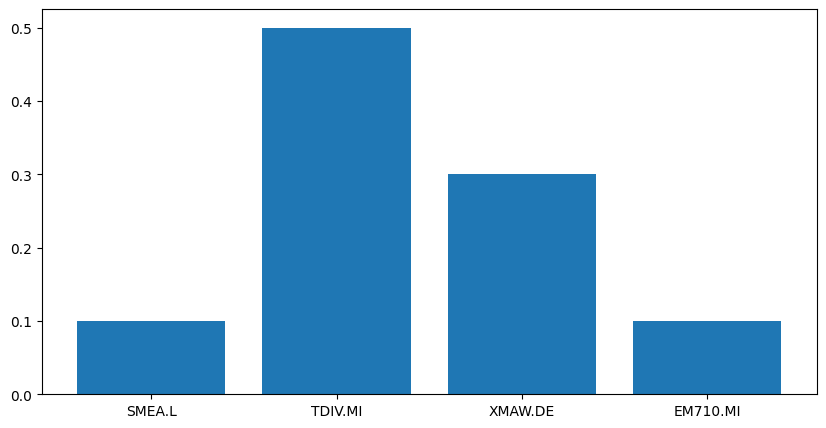

In [51]:
plt.figure(figsize=(10,5))
plt.bar(tickers,optimal_weights)
plt.show()